In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [2]:
num_imgs = 50000

img_size = 8
min_rect_size = 1
max_rect_size = 4
num_objects = 3

bboxes = np.zeros((num_imgs, num_objects, 4))
imgs = np.zeros((num_imgs, img_size, img_size))

for i_img in range(num_imgs):
    for i_object in range(num_objects):
        width, height = np.random.randint(min_rect_size, max_rect_size, size=2)
        x = np.random.randint(0, img_size - width)
        y = np.random.randint(0, img_size - height)
        imgs[i_img, x:x+width, y:y+height] = 1.
        bboxes[i_img, i_object] = [x, y, width, height]

imgs.shape, bboxes.shape

((50000, 8, 8), (50000, 3, 4))

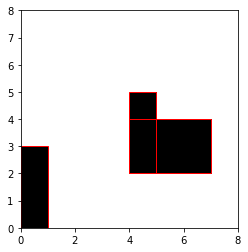

In [5]:
i = 20
plt.imshow(imgs[i].T, cmap='Greys', interpolation='none', origin='lower', 
           extent=[0, img_size, 0, img_size])

for bbox in bboxes[i]:
    plt.gca().add_patch(matplotlib.patches.Rectangle((bbox[0], bbox[1]), bbox[2],
                                                    bbox[3], ec='r', fc='none'))

In [6]:
X = (imgs.reshape(num_imgs, -1) - np.mean(imgs)) / np.std(imgs)
X.shape, np.mean(X), np.std(X)

((50000, 64), 6.508571459562518e-17, 1.0)

In [7]:
y = bboxes.reshape(num_imgs, -1) / img_size
y.shape

(50000, 12)

In [8]:
i = int(0.8 * num_imgs)
train_x = X[:i]
test_x = X[i:]
train_y = y[:i]
test_y = y[i:]

test_imgs = imgs[i:]
test_bboxes = bboxes[i:]

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import SGD
model = Sequential([
        Dense(256, input_dim=X.shape[-1]), 
        Activation('relu'), 
        Dropout(0.4), 
        Dense(y.shape[-1])
    ])
model.compile('adadelta', 'mse')

In [10]:
# Flip bboxes during training.

def IOU(bbox1, bbox2):
    '''Calculate overlap between two bounding boxes [x, y, w, h] as the area of intersection over the area of unity'''
    x1, y1, w1, h1 = bbox1[0], bbox1[1], bbox1[2], bbox1[3]  # TODO: Check if its more performant if tensor elements are accessed directly below.
    x2, y2, w2, h2 = bbox2[0], bbox2[1], bbox2[2], bbox2[3]

    w_I = min(x1 + w1, x2 + w2) - max(x1, x2)
    h_I = min(y1 + h1, y2 + h2) - max(y1, y2)
    if w_I <= 0 or h_I <= 0:  # no overlap
        return 0
    I = w_I * h_I

    U = w1 * h1 + w2 * h2 - I

    return I / U

def distance(bbox1, bbox2):
    return np.sqrt(np.sum(np.square(bbox1[:2] - bbox2[:2])))

num_epochs = 50
flipped_train_y = np.array(train_y)
flipped = np.zeros((len(flipped_train_y), num_epochs))
ious_epoch = np.zeros((len(flipped_train_y), num_epochs))
dists_epoch = np.zeros((len(flipped_train_y), num_epochs))
mses_epoch = np.zeros((len(flipped_train_y), num_epochs))

for epoch in range(num_epochs):
    print ('Epoch', epoch)
    model.fit(train_x, flipped_train_y, epochs=1, validation_data=(test_x, test_y), verbose=2)
    pred_y = model.predict(train_x)

    for sample, (pred_bboxes, exp_bboxes) in enumerate(zip(pred_y, flipped_train_y)):
        
        pred_bboxes = pred_bboxes.reshape(num_objects, -1)
        exp_bboxes = exp_bboxes.reshape(num_objects, -1)

        ious = np.zeros((num_objects, num_objects))
        dists = np.zeros((num_objects, num_objects))
        mses = np.zeros((num_objects, num_objects))
        for i, exp_bbox in enumerate(exp_bboxes):
            for j, pred_bbox in enumerate(pred_bboxes):
                ious[i, j] = IOU(exp_bbox, pred_bbox)
                dists[i, j] = distance(exp_bbox, pred_bbox)
                mses[i, j] = np.mean(np.square(exp_bbox - pred_bbox))
                
        new_order = np.zeros(num_objects, dtype=int)
        
        for i in range(num_objects):
            # Find pred and exp bbox with minimum mse and assign them to each other (i.e. switch the positions of the exp bboxes in y).
            ind_exp_bbox, ind_pred_bbox = np.unravel_index(mses.argmin(), mses.shape)
            ious_epoch[sample, epoch] += ious[ind_exp_bbox, ind_pred_bbox]
            dists_epoch[sample, epoch] += dists[ind_exp_bbox, ind_pred_bbox]
            mses_epoch[sample, epoch] += mses[ind_exp_bbox, ind_pred_bbox]
            mses[ind_exp_bbox] = 10000000#-1  # set mse of assigned bboxes to a large number, so they don't get assigned again
            mses[:, ind_pred_bbox] = 10000000#-1
            new_order[ind_pred_bbox] = ind_exp_bbox
        
        # Write flipped bboxes to training data.
        flipped_train_y[sample] = exp_bboxes[new_order].flatten()
        
        flipped[sample, epoch] = 1. - np.mean(new_order == np.arange(num_objects, dtype=int))#np.array_equal(new_order, np.arange(num_objects, dtype=int))  # TODO: Change this to reflect the number of flips.
        ious_epoch[sample, epoch] /= num_objects
        dists_epoch[sample, epoch] /= num_objects
        mses_epoch[sample, epoch] /= num_objects
        
            
    print ('Flipped {} % of all elements'.format(np.mean(flipped[:, epoch]) * 100.))
    print ('Mean IOU: {}'.format(np.mean(ious_epoch[:, epoch])))
    print ('Mean dist: {}'.format(np.mean(dists_epoch[:, epoch])))
    print ('Mean mse: {}'.format(np.mean(mses_epoch[:, epoch])))
    print ()

Epoch 0
1250/1250 - 1s - loss: 0.6392 - val_loss: 0.3435
Flipped 66.8325 % of all elements
Mean IOU: 0.00747168910332274
Mean dist: 0.6982997737996681
Mean mse: 0.3139095223651655

Epoch 1
1250/1250 - 1s - loss: 0.5244 - val_loss: 0.2788
Flipped 12.568333333333333 % of all elements
Mean IOU: 0.01087175114132516
Mean dist: 0.6320558517933458
Mean mse: 0.25156252573252363

Epoch 2
1250/1250 - 1s - loss: 0.4638 - val_loss: 0.2361
Flipped 11.8125 % of all elements
Mean IOU: 0.014449519571808338
Mean dist: 0.5823979672678445
Mean mse: 0.21036068188778312

Epoch 3
1250/1250 - 1s - loss: 0.4245 - val_loss: 0.2076
Flipped 10.5075 % of all elements
Mean IOU: 0.018007382140487617
Mean dist: 0.5452876082915377
Mean mse: 0.18304356910637198

Epoch 4
1250/1250 - 1s - loss: 0.3951 - val_loss: 0.1876
Flipped 8.455833333333334 % of all elements
Mean IOU: 0.021398819149667115
Mean dist: 0.516583649264049
Mean mse: 0.16368790942767714

Epoch 5
1250/1250 - 1s - loss: 0.3717 - val_loss: 0.1726
Flipped 7.0

Text(0, 0.5, 'Training sample')

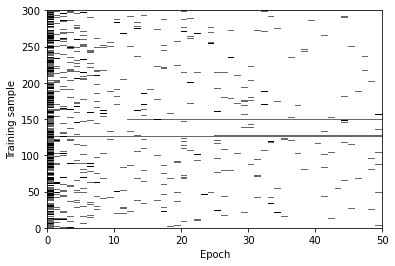

In [11]:
# Show flippings for a few training samples.
plt.pcolor(flipped[:300], cmap='Greys', vmax=1.)
plt.xlabel('Epoch')
plt.ylabel('Training sample')

(0.0, 1.0)

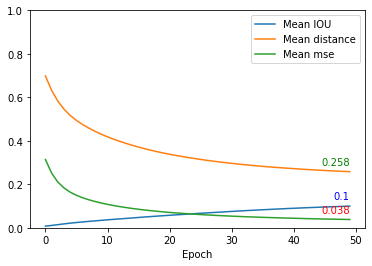

In [12]:
# Plot metrics on the training data. 
mean_ious_epoch = np.mean(ious_epoch, axis=0)
mean_dists_epoch = np.mean(dists_epoch, axis=0)
mean_mses_epoch = np.mean(mses_epoch, axis=0)
plt.plot(mean_ious_epoch, label='Mean IOU')  # between predicted and assigned true bboxes
plt.plot(mean_dists_epoch, label='Mean distance')  # relative to image size
plt.plot(mean_mses_epoch, label='Mean mse')
plt.annotate(np.round(np.max(mean_ious_epoch), 3), (len(mean_ious_epoch)-1, mean_ious_epoch[-1]+0.03), horizontalalignment='right', color='b')
plt.annotate(np.round(np.min(mean_dists_epoch), 3), (len(mean_dists_epoch)-1, mean_dists_epoch[-1]+0.03), horizontalalignment='right', color='g')
plt.annotate(np.round(np.min(mean_mses_epoch), 3), (len(mean_mses_epoch)-1, mean_mses_epoch[-1]+0.03), horizontalalignment='right', color='r')
plt.xlabel('Epoch')
plt.legend()
plt.ylim(0, 1)

# plt.savefig('plots/bw-three-rectangles-50k.png', dpi=300)

In [13]:
pred_y = model.predict(test_x)
pred_bboxes = pred_y * img_size
pred_bboxes = pred_bboxes.reshape(len(pred_bboxes), num_objects, -1)
pred_bboxes.shape

(10000, 3, 4)

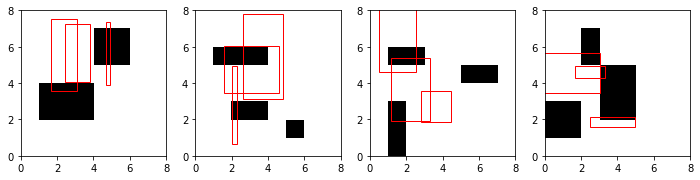

In [14]:
plt.figure(figsize=(12, 3))
for i_subplot in range(1, 5):
    plt.subplot(1, 4, i_subplot)
    i = np.random.randint(len(test_x))
    plt.imshow(test_imgs[i].T, cmap='Greys', interpolation='none', origin='lower', extent=[0, img_size, 0, img_size])
    for pred_bbox, exp_bbox in zip(pred_bboxes[i], test_bboxes[i]):
        plt.gca().add_patch(matplotlib.patches.Rectangle((pred_bbox[0], pred_bbox[1]), pred_bbox[2], pred_bbox[3], ec='r', fc='none'))
        # TODO: Calculate max IOU with all expected bounding boxes.
#         plt.annotate('IOU: {:.2f}'.format(IOU(pred_bbox, exp_bbox)), (pred_bbox[0], pred_bbox[1]+pred_bbox[3]+0.4), color='r')